## Only Historical Price Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gymnasium as gym
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy.typing as npt
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3 import DDPG
from stable_baselines3.common.noise import NormalActionNoise
from importlib import reload

from portfolio_env_framework import *
from data_utils import *
from rewards import *

In [6]:
class TrainDataManager(AbstractDataManager):
    def get_obs_space(self) -> gym.spaces.Box:
        return gym.spaces.Dict({
            'data': gym.spaces.Box(low=-np.inf, high=np.inf, shape=(3, self.universe_size, 10), dtype=np.float32),
            'weights': gym.spaces.Box(low=0, high=1, shape=(self.universe_size+1,), dtype=np.float32)
        })

    def get_data(self) -> tuple[int, int]:
        # read all data
        df = read_crsp_data()
        full_df = read_sec_data(pd.date_range(df.date.min(), df.date.max(), freq='D'), gamma=(1-1/5))
    
        # only include stocks that are present in all dates and in both datasets
        df_ticker_ok = df.TICKER.value_counts() == df.TICKER.value_counts().max()
        not_in_sent = full_df[pd.isnull(full_df.neg) & (full_df.fdate.dt.year > 2009)].TICKERH.unique()
        def is_max_val_count(ticker: str) -> bool:
          return df_ticker_ok[ticker] and (ticker not in ['GOOG', 'EXC']) and (ticker not in not_in_sent)
        df = df[df.apply(lambda row: is_max_val_count(row['TICKER']), axis=1)]
        df = df[(df.date.dt.year >= 2010) & (df.date.dt.year <= 2017)]
        self.times = df.date.unique()[1:]
        self.tickers = df.TICKER.unique()
    
        # create stock array
        self.stock_df = df.pivot(index='date', columns='TICKER', values='PRC').astype(float)
        self.high_df = df.pivot(index='date', columns='TICKER', values='ASKHI').astype(float)
        self.low_df = df.pivot(index='date', columns='TICKER', values='BIDLO').astype(float)
        
        # adjust for stock splits
        facpr_df = df.pivot(index='date', columns='TICKER', values='FACPR').astype(float)
        self.stock_df = self.stock_df * (1+facpr_df).cumprod(axis=0)
        self.high_df = self.high_df * (1+facpr_df).cumprod(axis=0)
        self.low_df = self.low_df * (1+facpr_df).cumprod(axis=0)
        self.ret = np.log(self.stock_df.pct_change().iloc[1:, :] + 1)
        
        self.num_time_periods = len(self.times)-15-1
        self.universe_size = len(self.tickers)
        print(f"{self.universe_size=}")
        return self.num_time_periods, self.universe_size
    
    def get_state(self, t: int, w: npt.NDArray[np.float64], port_val: np.float64) -> npt.NDArray[np.float64]:
        # today is self.times[self.t+10]
        s = np.zeros((3, self.universe_size, 10))
        s[0, :, :] = self.stock_df.loc[self.times[t:t+10], self.tickers].to_numpy().T
        s[1, :, :] = self.high_df.loc[self.times[t:t+10], self.tickers].to_numpy().T
        s[2, :, :] = self.low_df.loc[self.times[t:t+10], self.tickers].to_numpy().T
        return {'data': s, 'weights': w}

    def get_prices(self, t: int) -> npt.NDArray[np.float64]:
        # today is self.times[self.t+10]
        return np.append(self.stock_df.loc[self.times[t+10], :].to_numpy().flatten(), 1.0)

In [7]:
class TestDataManager(AbstractDataManager):
    def get_obs_space(self) -> gym.spaces.Box:
        return gym.spaces.Dict({
            'data': gym.spaces.Box(low=-np.inf, high=np.inf, shape=(3, self.universe_size, 10), dtype=np.float32),
            'weights': gym.spaces.Box(low=0, high=1, shape=(self.universe_size+1,), dtype=np.float32)
        })

    def get_data(self) -> tuple[int, int]:
        # read all data
        df = read_crsp_data()
        full_df = read_sec_data(pd.date_range(df.date.min(), df.date.max(), freq='D'), gamma=(1-1/5))
    
        # only include stocks that are present in all dates and in both datasets
        df_ticker_ok = df.TICKER.value_counts() == df.TICKER.value_counts().max()
        not_in_sent = full_df[pd.isnull(full_df.neg) & (full_df.fdate.dt.year > 2009)].TICKERH.unique()
        def is_max_val_count(ticker: str) -> bool:
          return df_ticker_ok[ticker] and (ticker not in ['GOOG', 'EXC']) and (ticker not in not_in_sent)
        df = df[df.apply(lambda row: is_max_val_count(row['TICKER']), axis=1)]
        df = df[(df.date.dt.year >= 2018) & (df.date.dt.year <= 2019)]
        self.times = df.date.unique()[1:]
        self.tickers = df.TICKER.unique()
    
        # create stock array
        self.stock_df = df.pivot(index='date', columns='TICKER', values='PRC').astype(float)
        self.high_df = df.pivot(index='date', columns='TICKER', values='ASKHI').astype(float)
        self.low_df = df.pivot(index='date', columns='TICKER', values='BIDLO').astype(float)
        
        # adjust for stock splits
        facpr_df = df.pivot(index='date', columns='TICKER', values='FACPR').astype(float)
        self.stock_df = self.stock_df * (1+facpr_df).cumprod(axis=0)
        self.high_df = self.high_df * (1+facpr_df).cumprod(axis=0)
        self.low_df = self.low_df * (1+facpr_df).cumprod(axis=0)
        self.ret = np.log(self.stock_df.pct_change().iloc[1:, :] + 1)

        # read index data and compute volatilities
        idx_df = pd.read_csv('crsp_snpidx_2010_to_2024.csv', dtype={
          'DATE': 'string',
          'vwretd': float
        })
        idx_df.DATE = pd.to_datetime(idx_df.DATE)
        idx_df['vol_20'] = idx_df.vwretd.rolling(20).std()
        idx_df['vol_60'] = idx_df.vwretd.rolling(60).std()
        idx_df.set_index('DATE', inplace=True)
        self.idx_df = idx_df
        
        self.num_time_periods = len(self.times)-15-1
        self.universe_size = len(self.tickers)
        print(f"{self.universe_size=}")
        return self.num_time_periods, self.universe_size
    
    def get_state(self, t: int, w: npt.NDArray[np.float64], port_val: np.float64) -> npt.NDArray[np.float64]:
        # today is self.times[self.t+10]
        s = np.zeros((3, self.universe_size, 10))
        s[0, :, :] = self.stock_df.loc[self.times[t:t+10], self.tickers].to_numpy().T
        s[1, :, :] = self.high_df.loc[self.times[t:t+10], self.tickers].to_numpy().T
        s[2, :, :] = self.low_df.loc[self.times[t:t+10], self.tickers].to_numpy().T
        return {'data': s, 'weights': w}

    def get_prices(self, t: int) -> npt.NDArray[np.float64]:
        # today is self.times[self.t+10]
        return np.append(self.stock_df.loc[self.times[t+10], :].to_numpy().flatten(), 1.0)

## CNN

In [12]:
class Custom_EIEE_CNN_Extractor(BaseFeaturesExtractor):
    def __init__(self, observation_space: gym.spaces.Dict, features_dim: int = 791):
        super(Custom_EIEE_CNN_Extractor, self).__init__(observation_space, features_dim)
        n_channels, self.universe_size, data_len = observation_space['data'].shape
        self.cnn = nn.Sequential(
            nn.Conv2d(n_channels, 3, kernel_size=(1, 3)),
            nn.ReLU(),
            nn.Conv2d(3, 5, kernel_size=(1, 3)),
            nn.ReLU(),
            nn.Conv2d(5, 7, kernel_size=(1, 3)),
            nn.ReLU(),
            nn.Conv2d(7, 9, kernel_size=(1, data_len-6)),
        )

    def forward(self, observations: dict[str, torch.Tensor]) -> torch.Tensor:
        x = self.cnn(observations['data'])
        return torch.cat((x.flatten(start_dim=1), observations['weights'].flatten(start_dim=1)), dim=1)

In [13]:
train_env = PortfolioEnvWithTCost(dm=TrainDataManager(), rm=DifferentialSharpeRatioReward(), cp=0.01, cs=0.01)

# Set seeds
random.seed(42)
np.random.seed(42)
train_env.action_space.seed(43)
torch.manual_seed(42)

model = DDPG('MultiInputPolicy', train_env, buffer_size=4*10**5, verbose=1, policy_kwargs={
  'features_extractor_class': Custom_EIEE_CNN_Extractor,
}, action_noise=NormalActionNoise(mean=0, sigma=0.02*np.ones(80)))
model.learn(total_timesteps=10**10, log_interval=1)
# model.save("cnn_portoflio_policy")

self.universe_size=79
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2e+03    |
|    ep_rew_mean     | 0.14     |
| time/              |          |
|    episodes        | 1        |
|    fps             | 38       |
|    time_elapsed    | 51       |
|    total_timesteps | 1996     |
| train/             |          |
|    actor_loss      | -0.0145  |
|    critic_loss     | 3.22e-05 |
|    learning_rate   | 0.001    |
|    n_updates       | 1895     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2e+03    |
|    ep_rew_mean     | 0.658    |
| time/              |          |
|    episodes        | 2        |
|    fps             | 36       |
|    time_elapsed    | 110      |
|    total_timesteps | 3992     |
| train/             |          |
|    actor_loss      | -0.0177  |

KeyboardInterrupt: 

In [8]:
# model.save("combined_cnn_0.02")

In [15]:
# model = DDPG.load("combined_cnn_0.02")

c:\Users\sumit\GitRepos\portfolio-rl\venv\Lib\site-packages\stable_baselines3\common\buffers.py:605: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 18.08GB > 13.88GB
  warnings.warn(


In [14]:
env = PortfolioEnvWithTCost(
    dm=TestDataManager(),
    rm=DifferentialSharpeRatioReward(),
    cp=0.01,#0.10/365,
    cs=0.01,#0.10/365
)
# env = make_vec_env(PortfolioEnvWithTCost, n_envs=1, env_kwargs={
#     'dm': TestDataManager(),
#     'rm': DifferentialSharpeRatioReward(),
#     'cp': 0.10/365,
#     'cs': 0.10/365
# })
obs, _ = env.reset()

port_val = [1.0]
snp_val = [1.0]
actions = []
ys = []
times_arr = [env.dm.times[env.t+10]]
mus = []

for i in range(900):
    action, _ = model.predict(obs, deterministic=True)
    actions.append(action)
    # print(f"external {action=}")
    obs, rewards, terminated, truncated, info = env.step(action)
    ys.append(env.y)
    mus.append(env.mu)
    times_arr.append(env.dm.times[env.t+10])
    port_val.append(info['port_val'])
    snp_val.append(snp_val[-1] * (1 + env.dm.idx_df[env.dm.idx_df.index == env.dm.times[env.t+10]].vwretd.values[0]))
    if terminated:
        break

self.universe_size=79


In [16]:
# model.save('pure_cnn_0.02')

In [17]:
# import pickle as pkl
# with open('pure_cnn_0.02_results.pkl', 'wb') as f:
#   pkl.dump({
#     'port_val': port_val,
#     'snp_val': snp_val,
#     'times_arr': times_arr,
#     'mus': mus,
#   }, f)


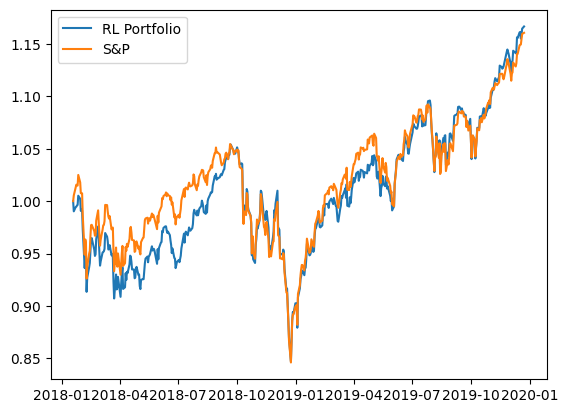

In [15]:
# std=0.02, 10m, profit
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

## RNN

In [22]:
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor

class Custom_EIEE_RNN_Extractor(BaseFeaturesExtractor):
    def __init__(self, observation_space: gym.spaces.Dict, features_dim: int = 870):
        super(Custom_EIEE_RNN_Extractor, self).__init__(observation_space, features_dim)
        n_channels, self.universe_size, data_len = observation_space['data'].shape
        self.lstm = nn.LSTM(input_size=n_channels, hidden_size=10, batch_first=True).cuda()

    def forward(self, observations: dict[str, torch.Tensor]) -> torch.Tensor:
        # assert len(observations['data'].shape) == 4 # (4, 3, 85, 100)
        obs = torch.permute(observations['data'], (0, 2, 3, 1)) # (4, 85, 100, 3)
        obs = obs.flatten(0, 1)
        x = self.lstm(obs)
        y = x[1][-1].squeeze()
        z = y.unflatten(0, (y.shape[0] // self.universe_size, self.universe_size))
        return torch.cat((z.squeeze(-1).flatten(1), observations['weights']), dim=1)

In [23]:
train_env = PortfolioEnvWithTCost(dm=TrainDataManager(), rm=DifferentialSharpeRatioReward(), cp=0.01, cs=0.01)

# Set seeds
random.seed(42)
np.random.seed(42)
train_env.action_space.seed(43)
torch.manual_seed(42)

model = DDPG('MultiInputPolicy', train_env, buffer_size=4*10**5, verbose=1, policy_kwargs={
  'features_extractor_class': Custom_EIEE_RNN_Extractor,
}, action_noise=NormalActionNoise(mean=0, sigma=0.08*np.ones(80)))
model.learn(total_timesteps=10**10, log_interval=1)
# model.save("cnn_portoflio_policy")

self.universe_size=79
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


KeyboardInterrupt: 

In [53]:
# model.save('ds_sec_model_rnn')

In [34]:
env = PortfolioEnvWithTCost(
    dm=TestDataManager(),
    # dm=TrainDataManager(),
    rm=DifferentialSharpeRatioReward(),
    cp=0.01,#0.10/365,
    cs=0.01,#0.10/365
)
obs, _ = env.reset()

port_val = [1.0]
snp_val = [1.0]
actions = []
ys = []
times_arr = [env.dm.times[env.t+10]]
mus = []

for i in range(900):
    action, _ = model.predict(obs, deterministic=True)
    actions.append(action)
    # print(f"external {action=}")
    obs, rewards, terminated, truncated, info = env.step(action)
    ys.append(env.y)
    mus.append(env.mu)
    times_arr.append(env.dm.times[env.t+10])
    port_val.append(info['port_val'])
    snp_val.append(snp_val[-1] * (1 + env.dm.idx_df[env.dm.idx_df.index == env.dm.times[env.t+10]].vwretd.values[0]))
    if terminated:
        break

self.universe_size=79


In [36]:
# model.save('combined_rnn_0.08')

In [37]:
# import pickle as pkl
# with open('combined_rnn_0.08_results.pkl', 'wb') as f:
#   pkl.dump({
#     'port_val': port_val,
#     'snp_val': snp_val,
#     'times_arr': times_arr,
#     'mus': mus,
#   }, f)


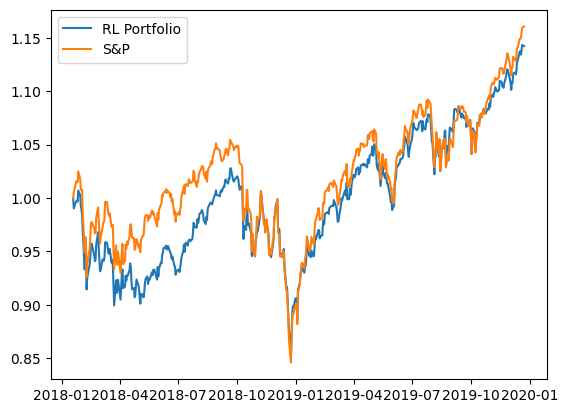

In [35]:
# std=0.08, 40min
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

## MLP

In [39]:
train_env = PortfolioEnvWithTCost(dm=TrainDataManager(), rm=DifferentialSharpeRatioReward(), cp=0.01, cs=0.01)

# Set seeds
random.seed(42)
np.random.seed(42)
train_env.action_space.seed(43)
torch.manual_seed(42)

model = DDPG('MultiInputPolicy', train_env, buffer_size=4*10**5, verbose=1, policy_kwargs={
}, action_noise=NormalActionNoise(mean=0, sigma=0.07*np.ones(80)))
model.learn(total_timesteps=10**10, log_interval=1)
# model.save("cnn_portoflio_policy")

self.universe_size=79
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


c:\Users\sumit\GitRepos\portfolio-rl\venv\Lib\site-packages\stable_baselines3\common\buffers.py:605: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 18.08GB > 10.79GB
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2e+03    |
|    ep_rew_mean     | -0.506   |
| time/              |          |
|    episodes        | 1        |
|    fps             | 32       |
|    time_elapsed    | 61       |
|    total_timesteps | 1996     |
| train/             |          |
|    actor_loss      | -27.3    |
|    critic_loss     | 2.69     |
|    learning_rate   | 0.001    |
|    n_updates       | 1895     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2e+03    |
|    ep_rew_mean     | -0.303   |
| time/              |          |
|    episodes        | 2        |
|    fps             | 31       |
|    time_elapsed    | 126      |
|    total_timesteps | 3992     |
| train/             |          |
|    actor_loss      | -24.9    |
|    critic_loss     | 0.0368   |
|    learning_rate   | 0.001    |
|    n_updates       | 3891     |
--------------

KeyboardInterrupt: 

In [7]:
# model.save('ds_sec_model_mlp')

In [40]:
env = PortfolioEnvWithTCost(
    dm=TestDataManager(),
    # dm=TrainDataManager(),
    rm=DifferentialSharpeRatioReward(),
    cp=0.01,#0.10/365,
    cs=0.01,#0.10/365
)
obs, _ = env.reset()

port_val = [1.0]
snp_val = [1.0]
actions = []
ys = []
times_arr = [env.dm.times[env.t+15]]
mus = []

for i in range(900):
    action, _ = model.predict(obs, deterministic=True)
    actions.append(action)
    # print(f"external {action=}")
    obs, rewards, terminated, truncated, info = env.step(action)
    ys.append(env.y)
    mus.append(env.mu)
    times_arr.append(env.dm.times[env.t+15])
    port_val.append(info['port_val'])
    snp_val.append(snp_val[-1] * (1 + env.dm.idx_df[env.dm.idx_df.index == env.dm.times[env.t+15]].vwretd.values[0]))
    if terminated:
        break

self.universe_size=79


In [42]:
# model.save('combined_mlp_0.07')

In [43]:
# import pickle as pkl
# with open('combined_mlp_0.07_results.pkl', 'wb') as f:
#   pkl.dump({
#     'port_val': port_val,
#     'snp_val': snp_val,
#     'times_arr': times_arr,
#     'mus': mus,
#   }, f)

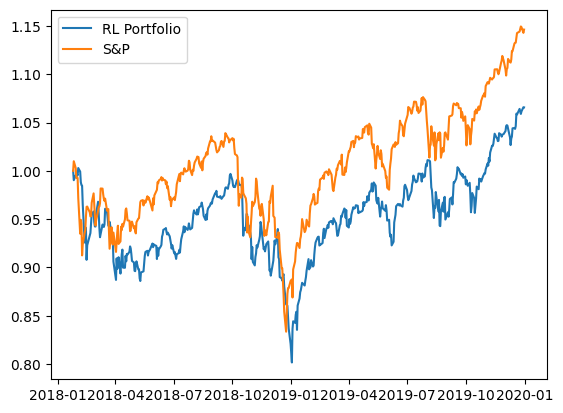

In [41]:
# std=0.07, 35m
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

## Combined Plot

In [12]:
cnn_model = DDPG.load('sec_model')
rnn_model = DDPG.load('sec_model_rnn')
mlp_model = DDPG.load('sec_model_mlp')

In [13]:
env = PortfolioEnvWithTCost(
    dm=TestDataManager(),
    rm=ProfitReward(),
    cp=0.01,#0.10/365,
    cs=0.01,#0.10/365
)

models = [cnn_model, rnn_model, mlp_model]
port_vals = []

for model in models:
  obs, _ = env.reset()

  port_val = [1.0]
  snp_val = [1.0]
  actions = []
  ys = []
  times_arr = [env.dm.times[env.t+15]]
  mus = []

  for i in range(900):
      action, _ = model.predict(obs, deterministic=True)
      actions.append(action)
      # print(f"external {action=}")
      obs, rewards, terminated, truncated, info = env.step(action)
      ys.append(env.y)
      mus.append(env.mu)
      times_arr.append(env.dm.times[env.t+15])
      port_val.append(info['port_val'])
      snp_val.append(snp_val[-1] * (1 + env.dm.idx_df[env.dm.idx_df.index == env.dm.times[env.t+15]].vwretd.values[0]))
      if terminated:
          break
  
  port_vals.append(port_val)

self.universe_size=79


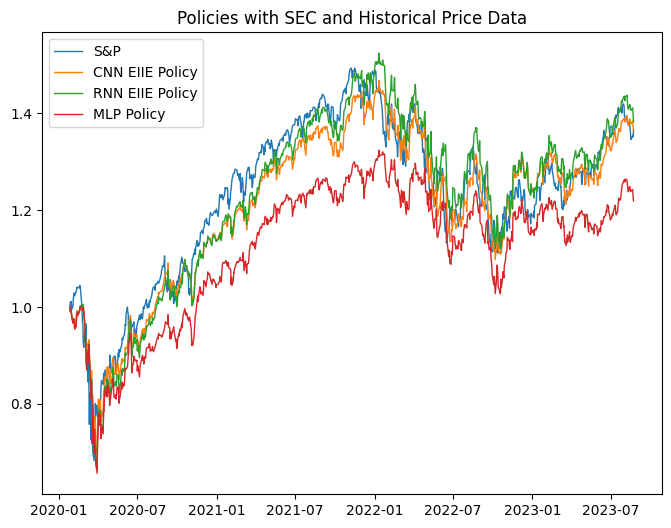

In [24]:
plt.figure(figsize=(8, 6))
plt.plot(times_arr, np.array(snp_val), label='S&P', lw=1)
plt.plot(times_arr, np.array(port_vals[0]), label='CNN EIIE Policy', lw=1)
plt.plot(times_arr, np.array(port_vals[1]), label='RNN EIIE Policy', lw=1)
plt.plot(times_arr, np.array(port_vals[2]), label='MLP Policy', lw=1)
# plt.yscale('log')
plt.legend()
plt.title('Policies with SEC and Historical Price Data')
plt.show()

In [26]:
df = read_crsp_data()
full_df = read_sec_data(pd.date_range(df.date.min(), df.date.max(), freq='D'), gamma=(1-1/5))
news_df = read_news_data(pd.date_range(df.date.min(), df.date.max(), freq='D'), gamma=(1-1/5))


# only include stocks that are present in all dates and in both datasets
df_ticker_ok = df.TICKER.value_counts() == df.TICKER.value_counts().max()
not_in_sent = full_df[pd.isnull(full_df.neg) & (full_df.fdate.dt.year > 2009)].TICKERH.unique()
def is_max_val_count(ticker: str) -> bool:
    return df_ticker_ok[ticker] and (ticker not in ['GOOG', 'EXC']) and (ticker not in not_in_sent)
df = df[df.apply(lambda row: is_max_val_count(row['TICKER']), axis=1)]
df = df[(df.date.dt.year >= 2010) & (df.date.dt.year <= 2019)]
times = df.date.unique()[1:]
tickers = df.TICKER.unique()
full_df = full_df[full_df.apply(lambda row: (row.TICKERH in tickers), axis=1)]
news_df = news_df[news_df.apply(lambda row: (row.ticker in tickers), axis=1)]

0       0.037281
1            NaN
2            NaN
3            NaN
4            NaN
          ...   
5841         NaN
5842         NaN
5843         NaN
5844         NaN
5845    0.010191
Name: AAPL, Length: 5846, dtype: float64
5846    0.015532
5847         NaN
5848         NaN
5849         NaN
5850         NaN
          ...   
9730         NaN
9731         NaN
9732         NaN
9733         NaN
9734    0.018307
Name: ABBV, Length: 3889, dtype: float64
9735     0.018966
9736          NaN
9737          NaN
9738          NaN
9739          NaN
           ...   
15465         NaN
15466         NaN
15467         NaN
15468         NaN
15469    0.014586
Name: ABT, Length: 5735, dtype: float64
15470    0.017032
15471         NaN
15472         NaN
15473         NaN
15474         NaN
           ...   
20733         NaN
20734         NaN
20735         NaN
20736         NaN
20737    0.014191
Name: ACN, Length: 5268, dtype: float64
20738    0.013713
20739         NaN
20740         NaN
20741         

In [27]:
# create stock array
stock_df = df.pivot(index='date', columns='TICKER', values='PRC').astype(float)
high_df = df.pivot(index='date', columns='TICKER', values='ASKHI').astype(float)
low_df = df.pivot(index='date', columns='TICKER', values='BIDLO').astype(float)

# adjust for stock splits
facpr_df = df.pivot(index='date', columns='TICKER', values='FACPR').astype(float)
stock_df = stock_df * (1+facpr_df).cumprod(axis=0)
high_df = high_df * (1+facpr_df).cumprod(axis=0)
low_df = low_df * (1+facpr_df).cumprod(axis=0)
ret = np.log(stock_df.pct_change().iloc[1:, :] + 1)

# create pivot tables
neg_sent_df = full_df.pivot(index='fdate', columns='TICKERH', values='neg').astype(float)
pos_sent_df = full_df.pivot(index='fdate', columns='TICKERH', values='pos').astype(float)
unc_sent_df = full_df.pivot(index='fdate', columns='TICKERH', values='unc').astype(float)
news_sentiment_array = news_df.pivot(index='date', columns='ticker', values= 'sentiment_embedding').astype(float)
no_sentiment_tickers = list(set(tickers) - set(news_sentiment_array.columns.values))

news_sentiment_array[[no_sentiment_tickers]] = 0
news_sent_df = news_sentiment_array

In [28]:
num_time_periods = len(times)-15-1
universe_size = len(tickers)

In [29]:
t = 0
s = np.zeros((7, universe_size, 10))
s[0, :, :] = stock_df.loc[times[t:t+10], tickers].to_numpy().T
s[1, :, :] = high_df.loc[times[t:t+10], tickers].to_numpy().T
s[2, :, :] = low_df.loc[times[t:t+10], tickers].to_numpy().T
s[3, :, :] = neg_sent_df.loc[times[t:t+10], tickers].to_numpy().T
s[4, :, :] = pos_sent_df.loc[times[t:t+10], tickers].to_numpy().T
s[5, :, :] = unc_sent_df.loc[times[t:t+10], tickers].to_numpy().T
s[6, :, : ] = news_sent_df.loc[times[t:t+10], tickers].to_numpy().T

In [30]:
s

array([[[2.48200000e+01, 2.44600000e+01, 2.43800000e+01, ...,
         2.53400000e+01, 2.52400000e+01, 2.53300000e+01],
        [3.09600000e+01, 3.07700000e+01, 3.04520000e+01, ...,
         3.09600000e+01, 3.08600000e+01, 3.11000000e+01],
        [4.04300000e+01, 4.04300000e+01, 4.12100000e+01, ...,
         4.25700000e+01, 4.26300000e+01, 4.28500000e+01],
        ...,
        [4.89200000e+01, 4.89200000e+01, 4.95300000e+01, ...,
         4.96000000e+01, 4.96200000e+01, 5.00900000e+01],
        [8.71300000e+01, 8.59600000e+01, 8.67600000e+01, ...,
         8.74400000e+01, 8.61400000e+01, 8.78500000e+01],
        [3.14800000e+01, 3.17900000e+01, 3.30100000e+01, ...,
         3.33200000e+01, 3.37500000e+01, 3.51300000e+01]],

       [[2.48500000e+01, 2.49150000e+01, 2.46100000e+01, ...,
         2.55800000e+01, 2.56400000e+01, 2.55000000e+01],
        [3.11000000e+01, 3.10800000e+01, 3.07000000e+01, ...,
         3.11000000e+01, 3.12400000e+01, 3.12400000e+01],
        [4.04600000e+01, 

In [19]:
model.load('tcost_portfolio_rl_model_framework_200_news.zip')

/Users/ravipanguluri/miniconda3/envs/portfolio-rl/lib/python3.12/site-packages/stable_baselines3/common/save_util.py:167: UserWarning: Could not deserialize object clip_range. Consider using `custom_objects` argument to replace this object.
Exception: code() argument 13 must be str, not int
  warnings.warn(
/Users/ravipanguluri/miniconda3/envs/portfolio-rl/lib/python3.12/site-packages/stable_baselines3/common/save_util.py:167: UserWarning: Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
Exception: code() argument 13 must be str, not int
  warnings.warn(
/Users/ravipanguluri/miniconda3/envs/portfolio-rl/lib/python3.12/site-packages/stable_baselines3/common/buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 164.83GB > 6.15GB
  warnings.warn(


AttributeError: 'ActorCriticPolicy' object has no attribute 'actor'

In [33]:
custom_objects = {
            "learning_rate": 0.0,
            "lr_schedule": lambda _: 0.0,
            "clip_range": lambda _: 0.0,
            "policy_kwargs":
            {
                'features_extractor_class': Custom_EIEE_CNN_Extractor
                }
        }

model = DDPG.load('cnn_sec_and_news_model_gcloud', custom_objects=custom_objects, env = env)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/Users/ravipanguluri/miniconda3/envs/portfolio-rl/lib/python3.12/site-packages/stable_baselines3/common/buffers.py:605: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 18.08GB > 5.35GB
  warnings.warn(


RuntimeError: Error(s) in loading state_dict for MultiInputPolicy:
	Missing key(s) in state_dict: "critic.qf1.0.weight", "critic.qf1.0.bias", "critic.qf1.2.weight", "critic.qf1.2.bias", "critic.qf1.4.weight", "critic.qf1.4.bias", "critic_target.qf1.0.weight", "critic_target.qf1.0.bias", "critic_target.qf1.2.weight", "critic_target.qf1.2.bias", "critic_target.qf1.4.weight", "critic_target.qf1.4.bias". 